<a href="https://colab.research.google.com/github/pravinkr/GAN-Keras/blob/master/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division


import tensorflow as tf

from keras.models import Model, Sequential, load_model
from keras.layers import Conv2D,  Dropout, Flatten, Dense, Input, Reshape, UpSampling2D, BatchNormalization
from keras.layers import Activation, Conv2DTranspose
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist, fashion_mnist
from keras.optimizers import Adam, RMSprop
from PIL import Image
from tqdm import tqdm
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline


class GAN:

	def __init__(self, rows=28, cols=28, channels=1):
		self.rows = rows
		self.cols = cols
		self.channels = channels
		self.shape = (self.rows, self.cols, self.channels)
		self.latent_size = 100
		self.sample_rows = 5
		self.sample_cols = 5
		self.sample_path = 'images'

		optimizer = RMSprop(lr=0.0008, clipvalue=1.0, decay=6e-8)
		
		
		image_shape = self.shape
		seed_size = self.latent_size
		
		#Get the discriminator and generator Models
		print("Build Discriminator")
		self.discriminator = self.build_discriminator()
		
		self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  
		print("Build Generator")
		
		self.generator = self.build_generator(seed_size)
		
		random_input = Input(shape=(seed_size,))
		generated_image = self.generator(random_input)
		
		self.discriminator.trainable = False
		validity = self.discriminator(generated_image)
		
		self.combined_model = Model(random_input, validity)
		self.combined_model.compile(loss='binary_crossentropy', optimizer=optimizer,metrics=['accuracy'])
		
	def build_discriminator1(self):
	
		input_shape = self.shape
		model = Sequential()
		model.add(Conv2D(64, (3,3), strides=2, padding='same', input_shape=input_shape))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(128,(3,3), strides=2, padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(256, (3,3), strides=2, padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Conv2D(512, (3,3), padding='same'))
		model.add(LeakyReLU(alpha=0.2))
		model.add(Dropout(0.4))
		
		model.add(Flatten())
		
		model.add(Dense(1,activation='sigmoid'))
		
		#output = model
		#inp = Input(shape=input_shape) 
		
		
		#model.summary()
		
		input_image = Input(shape=input_shape)
		
		validity = model(input_image)
		
		return Model(input_image,validity)	

	def build_discriminator(self):
	
		def conv_block(x,filter_size,strides=2, padding='same' ):
			x = Conv2D(filter_size, (3,3), strides = strides, padding = padding)(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = Dropout(0.3)(x)
			return x
		
		input_shape = (self.rows, self.cols, self.channels)
		
		input_image = Input(shape=input_shape)
		
		x = conv_block(input_image, 64, strides=(2,2))
		x = conv_block(x, 128, strides=(1,1))
		x = conv_block(x,256, strides=(2,2))
		x = conv_block(x,512, (1,1))
		
		features = Flatten()(x)
		real_or_fake = Dense(1, activation='sigmoid')(features)
		
		
		return Model(input_image,real_or_fake)

	def build_generator(self, latent_size):
	
	
		seed_size = latent_size
		model = Sequential()
		model.add(Dense(7*7*256, input_dim=seed_size))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Reshape((7,7,256)))
		model.add(Dropout(0.4))
		
		model.add(Conv2DTranspose(128,(5,5),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(64,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		model.add(UpSampling2D())
		
		model.add(Conv2DTranspose(32,(3,3),padding='same'))
		model.add(BatchNormalization(momentum=0.9))
		model.add(Activation('relu'))
		
		model.add(Conv2DTranspose(1,(3,3),padding='same'))
		model.add(Activation('sigmoid'))
		
		input = Input(shape=(seed_size,))
		
		generated_image = model(input)
		
		#model.summary()
		
		return(Model(input,generated_image))

		
	def build_generator1(self, latent_size):
	
		def up_sampling_block(x, filter_size):
			x = UpSampling2D(size=(2,2))(x)
			x = Conv2D(filter_size, (5,5), padding='same',activation='relu')(x)
			return x
		
		latent_input = Input(shape=(latent_size,))
		
		x = Dense(1024, activation='relu')(latent_input)
		x = Dense(7*7*512,activation='relu')(x)
		x = Reshape((7,7,512))(x)
		x = Conv2D(256, (3,3), padding='same')(x)
		
		x = up_sampling_block(x,128)
		x = up_sampling_block(x,64)
		#x = up_sampling_block(x,32)
		x = Conv2D(32, (3,3), padding='same')(x)
		
		gen_image = Conv2D(1, (3,3), padding='same')(x)
		
		model = Model(latent_input, gen_image)
		
		return model


	def plot_sample_images(self, epoch, noise):
		r, c = self.sample_rows, self.sample_cols
		#noise = np.random.normal(0, 1, (r * c, self.latent_size))
		gen_imgs = self.generator.predict(noise)
		#print("gen_imgs.shape",gen_imgs.shape)
		
		# Rescale images 0 - 1
		#gen_imgs = 0.5 * gen_imgs + 0.5
		#gen_imgs = gen_imgs.reshape(gen_imgs.shape[0], self.rows, self.cols,1)

		
		filename = os.path.join(self.sample_path,'%d.png'% epoch)
		fig, axs = plt.subplots(r, c)
		cnt = 0
		for i in range(r):
			for j in range(c):
				axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
				axs[i,j].axis('off')
				cnt += 1
		#fig.savefig("images/%d.png" % epoch)
		fig.savefig(filename)
		plt.close()


	def plot_loss(self,losses):
		"""
		@losses.keys():
			0: loss
			1: accuracy
		"""
		d_loss = [v[0] for v in losses["D"]]
		g_loss = [v[0] for v in losses["G"]]
		
		plt.figure(figsize=(10,8))
		plt.plot(d_loss, label="Discriminator loss")
		plt.plot(g_loss, label="Generator loss")
		
		plt.xlabel('Epochs')
		plt.ylabel('Loss')
		plt.legend()
		plt.show()

		
	def train(self, epochs=10000, batch_size=32, save_freq=200):
   
		seed_size = self.latent_size
		
    #Load Dataset
		#(x_train,_),(_,_) = mnist.load_data()
		(x_train,_),(_,_) = fashion_mnist.load_data()
		
		#normalize and reset train set in range (0,1) # normalizing to (-1,1) seems to be not working.
		
		x_train = np.expand_dims(x_train, axis=-1)

		#x_train = (x_train.astype('float32') / 127.5 ) - 1. # Normalizing this way doesn't work during training.
		
		x_train = x_train.astype('float32')/255.0 #Normalizing  this way does work during training.
		
  
		print("x_train.shape",x_train.shape)

    #Ground Truth. Setting real images labels to True
		y_real = np.ones((batch_size,1))

    #Setting fake images labels to False
		y_fake = np.zeros((batch_size,1))
		
    
		#fixed_seed = np.random.normal(0,1,size=[25,seed_size])
		
		cnt = 1
		
		#Generating Fixed noise to be passed for sampling with same inputs after set of epochs and seeing the results
		noise_input = np.random.normal(0,1,size=[self.sample_rows*self.sample_cols,seed_size])
		
		#Setup loss vector to store losses for Generator and Discriminator
		
		losses = {"D":[], "G":[]}

		path = self.sample_path
		if not os.path.isdir(path):
		  os.mkdir(path)

		for epoch in range(epochs):


      #Training of Discriminator. Taking random samples of batch_size #
			noise = np.random.normal(0,1,size=[batch_size,seed_size])
			
      #take random batched of indexes for x_train
			idx = np.random.randint(0,x_train.shape[0],size=batch_size)
			
			#print(idx[0:10])
			x_real = x_train[idx]
			
			#print("x_real.shape",x_real.shape)
			
			#Generate some fake images
			x_fake = self.generator.predict(noise)
      
			x = np.concatenate((x_real,x_fake))
			
			y = np.ones([2*batch_size,1])
			y[batch_size:,:] = 0
			
			#Train discriminator on real and fake
			d_loss = self.discriminator.train_on_batch(x,y)
			
			#Train Generator on Calculated loss
			y = np.ones([batch_size, 1])

			#noise = np.random.uniform(-1.0, 1.0, size=[batch_size, SEED_SIZE])
			noise = np.random.normal(0,1,size=[batch_size,seed_size])
			
			g_loss = self.combined_model.train_on_batch(noise,y)
			
			losses["D"].append(d_loss)
			losses["G"].append(g_loss)
			
			#Time for an update
			
			if save_freq > 0:
				if epoch % save_freq == 0:

					print ("epoch %d: [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], 100*g_loss[1]))

					self.plot_sample_images(epoch, noise_input)
					cnt+=1

		self.plot_loss(losses)
		


		
	
	  
	
	
		
		


Using TensorFlow backend.


Build Discriminator




Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Build Generator








4423680/4422102 [==============================] - 1s 0us/step
x_train.shape (60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




epoch 0: [D loss: 0.691365, acc.: 60.94%] [G loss: 1.201871, acc.: 0.00%]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


epoch 200: [D loss: 0.294235, acc.: 90.62%] [G loss: 0.743313, acc.: 56.25%]
epoch 400: [D loss: 0.512694, acc.: 79.69%] [G loss: 1.189615, acc.: 12.50%]
epoch 600: [D loss: 0.844212, acc.: 57.81%] [G loss: 0.478402, acc.: 75.00%]
epoch 800: [D loss: 0.607593, acc.: 62.50%] [G loss: 3.226438, acc.: 3.12%]
epoch 1000: [D loss: 0.581516, acc.: 70.31%] [G loss: 2.427681, acc.: 9.38%]
epoch 1200: [D loss: 0.523288, acc.: 76.56%] [G loss: 0.846732, acc.: 43.75%]
epoch 1400: [D loss: 0.268155, acc.: 90.62%] [G loss: 1.926089, acc.: 0.00%]
epoch 1600: [D loss: 0.392533, acc.: 84.38%] [G loss: 2.513028, acc.: 9.38%]
epoch 1800: [D loss: 0.402593, acc.: 81.25%] [G loss: 1.513018, acc.: 25.00%]
epoch 2000: [D loss: 0.393549, acc.: 79.69%] [G loss: 1.170088, acc.: 34.38%]
epoch 2200: [D loss: 0.506550, acc.: 76.56%] [G loss: 1.427012, acc.: 28.12%]
epoch 2400: [D loss: 0.382758, acc.: 81.25%] [G loss: 2.613023, acc.: 3.12%]
epoch 2600: [D loss: 0.348792, acc.: 78.12%] [G loss: 3.163424, acc.: 0.0

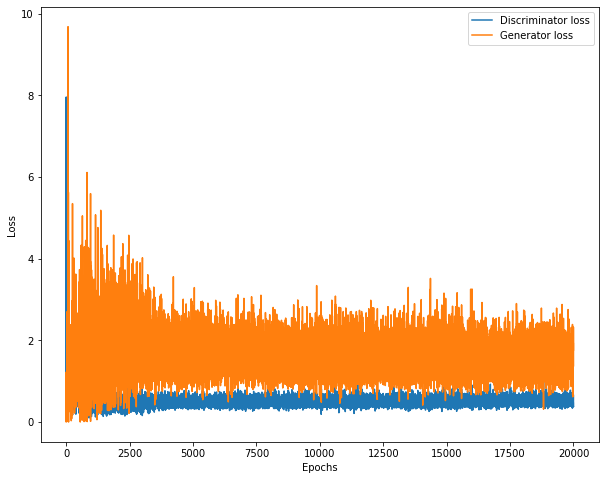

In [0]:
gan = GAN()

gan.train(epochs=20000)